# Introducción y Contexto

## Objetivo del Notebook
Este notebook tiene como objetivo replicar y analizar los hallazgos del estudio "Discrimination in the rental housing market: A field experiment on the Internet" por Ali M. Ahmed y Mats Hammarstedt. El propósito es comprender mejor las dinámicas de discriminación en el mercado de alquiler de viviendas utilizando un enfoque experimental en Internet.

## Resumen del Paper
En este estudio, Ahmed y Hammarstedt presentaron un experimento de campo para investigar la discriminación en el mercado de alquiler de viviendas en Suecia utilizando Internet como plataforma. Crearon tres personas ficticias con nombres distintivamente étnicos y de género, quienes solicitaron apartamentos vacantes anunciados en Internet. Los resultados mostraron que el hombre con nombre árabe/musulmán recibió significativamente menos respuestas y oportunidades de mostrar viviendas en comparación con el hombre sueco. Además, la mujer sueca encontró menos dificultades para encontrar un apartamento en comparación con el hombre sueco, lo que indica la existencia de discriminación tanto étnica como de género en el mercado sueco de alquiler de viviendas
## Importancia de la Replicación
La replicación de este estudio es crucial para validar sus hallazgos y entender mejor las tendencias de discriminación en contextos similares. Además, al replicar este experimento, podemos examinar más de cerca:
- **La metodología del Experimento**: Comprender cómo se diseñó y ejecutó el experimento para estudiar la discriminación.
- **La Dinámica de Discriminación en el Mercado de Viviendas**: Explorar en profundidad las formas en que se manifiesta la discriminación en el mercado de alquiler y cómo esto puede variar según el contexto geográfico y cultural.
- **La Aplicabilidad de los Resultados**: Evaluar hasta qué punto los hallazgos del estudio original son aplicables a otros mercados de alquiler, especialmente en contextos con diversas composiciones demográficas y hábitos de uso de Internet similares a los de Suecia.




# Dependencias

In [2]:
install.packages("DeclareDesign")
install.packages("margins")
require("DeclareDesign")
require("DesignLibrary")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Formula’, ‘Rcpp’, ‘RcppEigen’, ‘randomizr’, ‘fabricatr’, ‘estimatr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘prediction’


Loading required package: DeclareDesign

Loading required package: randomizr

Loading required package: fabricatr

Loading required package: estimatr

Loading required package: DesignLibrary

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘DesignLibrary’”


# Modelo: Simple

In [1]:
panels <- fabricate(
  listings = add_level(N = 17000, listing_fe = runif(N, -.05, .05)),
  hours = add_level(N = 3, hour_shock = runif(N, -0.0, 0.0), nest = FALSE),
  obs = cross_levels(
    by = join_using(listings, hours),
    U =rnorm(N, 0, .02),
    epsilon = listing_fe + hour_shock + U
  )

)

require(tidyverse)
panels  %>% arrange(listings)

ERROR: ignored

In [54]:
design0 <- declare_model(
  panels,
          potential_outcomes(
            Y ~ rbinom(n = N, size = 1,
                      prob = case_when(
                        Z == 0~  0.46 + epsilon,
                        Z == 1 ~ 0.564 + epsilon,
                        Z == 2 ~ 0.212 + epsilon,
                        TRUE ~ NA_real_
                      )
            ),
            conditions = list(Z = c(0, 1, 2))
          )
        ) + NULL

head(draw_data(design0) %>% arrange(listings),10)

,listings,listing_fe,hours,hour_shock,obs,U,epsilon,Y_Z_0,Y_Z_1,Y_Z_2
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>
1,0001,-0.01894711,1,0,0001,2.126990e-02,0.002322793,1,0,0
2,0001,-0.01894711,2,0,1701,-2.800337e-02,-0.046950480,0,0,0
3,0001,-0.01894711,3,0,3401,-1.783316e-03,-0.020730423,0,0,0
4,0002,-0.03574500,1,0,0002,3.384222e-04,-0.035406582,0,1,0
5,0002,-0.03574500,2,0,1702,-2.303645e-02,-0.058781453,0,0,0
6,0002,-0.03574500,3,0,3402,-9.645112e-05,-0.035841455,1,1,0
7,0003,-0.04983908,1,0,0003,-1.097480e-02,-0.060813883,0,0,0
8,0003,-0.04983908,2,0,1703,-4.733542e-02,-0.097174500,1,1,0
9,0003,-0.04983908,3,0,3403,1.964184e-02,-0.030197241,1,1,0


In [67]:
require("margins") # for margins
require(broom) # for tidy

tidy_margins <- function(x) {
  tidy(margins(x, data = x$data), conf.int = TRUE)
}


In [77]:
design0 <- declare_model(
  panels,
          potential_outcomes(
            Y ~ rbinom(n = N, size = 1,
                      prob = case_when(
                        Z == 0~  0.46 + epsilon,
                        Z == 1 ~ 0.564 + epsilon,
                        Z == 2 ~ 0.212 + epsilon,
                        TRUE ~ NA_real_
                      )
            ),
            conditions = list(Z = c(0, 1, 2))
          )
        ) + NULL

design0 <- declare_model(
  panels,
  potential_outcomes(
    Y ~ rbinom(n = N, size = 1,
               prob = case_when(
                 Z == 0 ~ 0.46 + epsilon,
                 Z == 1 ~ 0.564 + epsilon,
                 Z == 2 ~ 0.212 + epsilon,
                 TRUE ~ NA_real_
               )
    ),
    conditions = list(Z = c(0, 1, 2))
  )
) +
declare_inquiry(
          ATE1 = mean(Y_Z_1-Y_Z_0),
          ATE2 = mean(Y_Z_2-Y_Z_0)) +
        declare_sampling(S = complete_rs(N = N, n = 500)) +
        declare_assignment(Z = block_ra(blocks = listings)) +
        declare_measurement(Y = reveal_outcomes(Y ~ Z)) +
        declare_estimator(model = lm, formula = Y ~ Z, term = "Z", label = "OLS") +
        declare_estimator(model = lm, formula = Y ~ Z + factor(listings) + factor(hours), term = "Z", label = "FE") +
        declare_estimator(model = glm, formula = Y ~ Z, family = "binomial", label = "Probit", .summary = tidy_margins)



In [62]:
table(draw_data(design0)$Z)


  0   1 
247 253 

In [71]:
ate_Y_2_1 = difference_in_means(formula = Y ~ Z, data = data, condition1 = "1", condition2 = "2")
ate_Y_3_1 = difference_in_means(formula = Y ~ Z, data = data, condition1 = "1", condition2 = "3")
ate_Y_3_2 = difference_in_means(formula = Y ~ Z, data = data, condition1 = "2", condition2 = "3")

ERROR: ignored

In [78]:
diagnosis <- diagnose_design(design0 , sims = 1000)
tidy(diagnosis)

Streaming output truncated to the last 5000 lines.
Warning message in fn(data, formula = ~(Y ~ Z), model = ~lm, term = ~"Z"):
“The argument 'model = ' is deprecated. Please use '.method = ' instead.”
Warning message in fn(data, formula = ~(Y ~ Z + factor(listings) + factor(hours)), :
“The argument 'model = ' is deprecated. Please use '.method = ' instead.”
Warning message in fn(data, formula = ~(Y ~ Z), family = ~"binomial", .summary = ~tidy_margins, :
“The argument 'model = ' is deprecated. Please use '.method = ' instead.”
Warning message in fn(data, formula = ~(Y ~ Z), model = ~lm, term = ~"Z"):
“The argument 'model = ' is deprecated. Please use '.method = ' instead.”
Warning message in fn(data, formula = ~(Y ~ Z + factor(listings) + factor(hours)), :
“The argument 'model = ' is deprecated. Please use '.method = ' instead.”
Warning message in fn(data, formula = ~(Y ~ Z), family = ~"binomial", .summary = ~tidy_margins, :
“The argument 'model = ' is deprecated. Please use '.method = '

design,inquiry,estimator,term,diagnosand,estimate,std.error,conf.low,conf.high
<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
design0,ATE1,FE,Z,mean_estimand,0.103809804,0.0003295246,0.103135093,0.1043849363
design0,ATE1,FE,Z,mean_estimate,0.096464112,0.0031422336,0.090586906,0.1024463473
design0,ATE1,FE,Z,bias,-0.007345692,0.0031294985,-0.013027314,-0.0012903047
design0,ATE1,FE,Z,sd_estimate,0.108911448,0.0028587791,0.103378514,0.1135346761
design0,ATE1,FE,Z,rmse,0.108603303,0.0027864222,0.103516914,0.1133772656
design0,ATE1,FE,Z,power,0.158000000,0.0113391073,0.136900000,0.1805750000
design0,ATE1,FE,Z,coverage,0.942000000,0.0075879423,0.927950000,0.9560500000
design0,ATE1,OLS,Z,mean_estimand,0.103809804,0.0003295246,0.103135093,0.1043849363
design0,ATE1,OLS,Z,mean_estimate,0.101375249,0.0013149975,0.098831040,0.1038693147


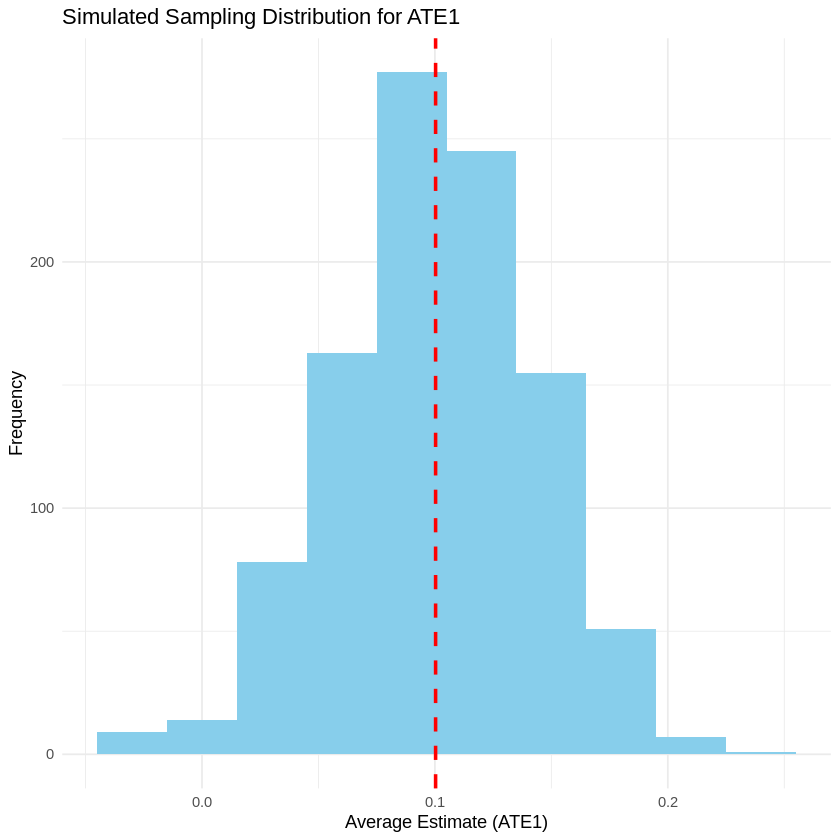

In [90]:
library(ggplot2)

# Supongamos que 'diagnosis' es el objeto que contiene los resultados de diagnose_design
# y que get_simulations(diagnosis) obtiene las simulaciones para graficar.

# Crear una visualización de la distribución de muestreo simulada
simulations_ate1 <- get_simulations(diagnosis) %>%
  filter(inquiry == "ATE1" & estimator="Probit") # Asegúrate de que 'ate_group' es el nombre correcto de la columna

# Crear una visualización para ATE1
ggplot(data = simulations_ate1, aes(x = estimate)) +
  geom_histogram(binwidth = 0.03, fill = 'skyblue') +
  geom_vline(aes(xintercept = mean(estimate)), color = "red", linetype = "dashed", size = 1) +
  xlab('Average Estimate (ATE1)') +
  ylab('Frequency') +
  ggtitle('Simulated Sampling Distribution for ATE1') +
  theme_minimal()

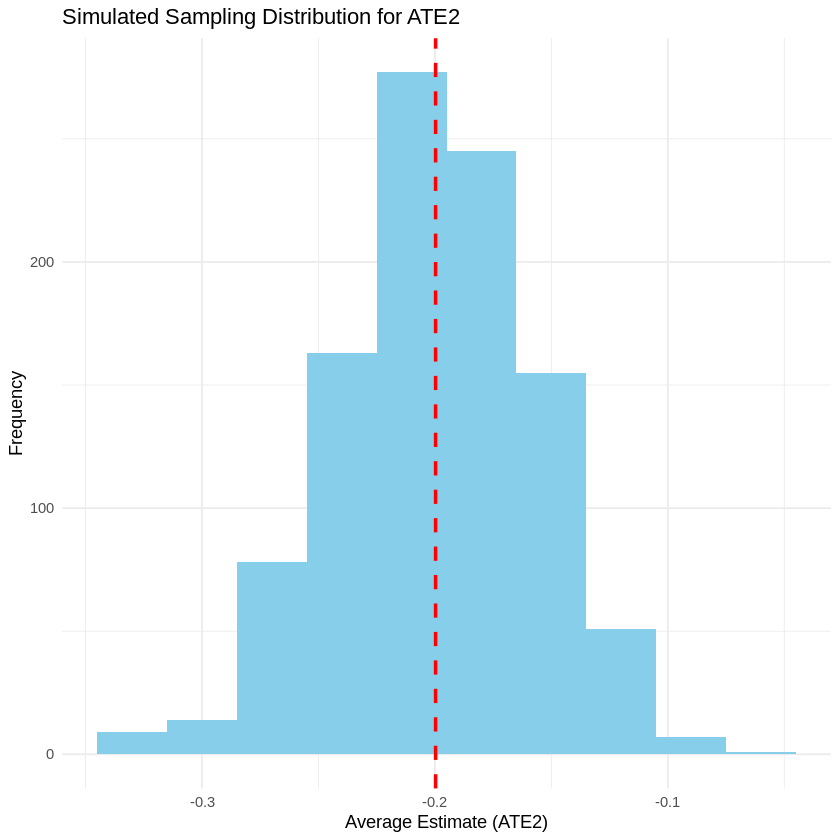

In [95]:
library(ggplot2)

# Supongamos que 'diagnosis' es el objeto que contiene los resultados de diagnose_design
# y que get_simulations(diagnosis) obtiene las simulaciones para graficar.

# Crear una visualización de la distribución de muestreo simulada
simulations_ate2 <- get_simulations(diagnosis) %>%
  filter(inquiry == "ATE2" & estimator=="Probit") # Asegúrate de que 'ate_group' es el nombre correcto de la columna

# Crear una visualización para ATE1
ggplot(data = simulations_ate2, aes(x = estimate-0.3)) +
  geom_histogram(binwidth = 0.03, fill = 'skyblue') +
  geom_vline(aes(xintercept = mean(estimate-0.3)), color = "red", linetype = "dashed", size = 1) +
  xlab('Average Estimate (ATE2)') +
  ylab('Frequency') +
  ggtitle('Simulated Sampling Distribution for ATE2') +
  theme_minimal()

# Modelo Ampliado: teniendo en cuenta inmigrand y native en el landlord

In [99]:
panels <- fabricate(
  listings = add_level(
    N = 17000,
    listing_fe = runif(N, -0.05, 0.05),
    native = rbinom(N, size = 1, prob = 0.768), # Genera la variable nativo
    immigrant = rbinom(N, size = 1, prob = 0.068) # Genera la variable inmigrante
  ),
  hours = add_level(N = 3, hour_shock = runif(N, -0.0, 0.0), nest = FALSE),
  obs = cross_levels(
    by = join_using(listings, hours),
    U = rnorm(N, 0, .02),
    epsilon = listing_fe + hour_shock + U
  )
)


In [109]:
# Ahora, ajusta el modelo potencial de resultados para incorporar nativo e inmigrante
design0 <- declare_model(
  panels,
  potential_outcomes(
    Y ~ rbinom(n = N, size = 1,
               prob = case_when(
                 Z == 0 ~ 0.46 + epsilon ,
                 Z == 1 ~ 0.564 + epsilon - immigrant * 0.013,
                 Z == 2 ~ 0.212 + epsilon - immigrant * 0.076,
                 TRUE ~ NA_real_
               )
    ),
    conditions = list(Z = c(0, 1, 2))
  )
) +
declare_inquiry(
          ATE1 = mean(Y_Z_1-Y_Z_0),
          ATE2 = mean(Y_Z_2-Y_Z_0)) +
        declare_sampling(S = complete_rs(N = N, n = 500)) +
        declare_assignment(Z = block_ra(blocks = listings)) +
        declare_measurement(Y = reveal_outcomes(Y ~ Z)) +
        declare_estimator(model = lm, formula = Y ~ Z, term = "Z", label = "OLS") +
        declare_estimator(model = lm, formula = Y ~ Z + factor(listings) + factor(hours), term = "Z", label = "FE") +
        declare_estimator(model = glm, formula = Y ~ Z, family = "binomial", label = "Probit", .summary = tidy_margins)



In [110]:
diagnosis <- diagnose_design(design0 , sims = 500)
tidy(diagnosis)

Warning message in fn(data, formula = ~(Y ~ Z), model = ~lm, term = ~"Z"):
“The argument 'model = ' is deprecated. Please use '.method = ' instead.”
Warning message in fn(data, formula = ~(Y ~ Z + factor(listings) + factor(hours)), :
“The argument 'model = ' is deprecated. Please use '.method = ' instead.”
Warning message in fn(data, formula = ~(Y ~ Z), family = ~"binomial", .summary = ~tidy_margins, :
“The argument 'model = ' is deprecated. Please use '.method = ' instead.”
Warning message in fn(data, formula = ~(Y ~ Z), model = ~lm, term = ~"Z"):
“The argument 'model = ' is deprecated. Please use '.method = ' instead.”
Warning message in fn(data, formula = ~(Y ~ Z + factor(listings) + factor(hours)), :
“The argument 'model = ' is deprecated. Please use '.method = ' instead.”
Warning message in fn(data, formula = ~(Y ~ Z), family = ~"binomial", .summary = ~tidy_margins, :
“The argument 'model = ' is deprecated. Please use '.method = ' instead.”
Warning message in fn(data, formula = ~(

design,inquiry,estimator,term,diagnosand,estimate,std.error,conf.low,conf.high
<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
design0,ATE1,FE,Z,mean_estimand,0.103241569,0.0003873112,0.102418873,0.1039398431
design0,ATE1,FE,Z,mean_estimate,0.098785069,0.0048684748,0.089679373,0.1080334510
design0,ATE1,FE,Z,bias,-0.004456499,0.0048321807,-0.013188029,0.0047432923
design0,ATE1,FE,Z,sd_estimate,0.108329704,0.0031033089,0.101834345,0.1149076957
design0,ATE1,FE,Z,rmse,0.108589292,0.0030661793,0.102704801,0.1154830292
design0,ATE1,FE,Z,power,0.150000000,0.0159519480,0.120950000,0.1790500000
design0,ATE1,FE,Z,coverage,0.936000000,0.0097815328,0.918950000,0.9570500000
design0,ATE1,OLS,Z,mean_estimand,0.103241569,0.0003873112,0.102418873,0.1039398431
design0,ATE1,OLS,Z,mean_estimate,0.100243187,0.0021432092,0.095734988,0.1032243053
